In [5]:
dataset = "P-SET"
llm_type = "llama3.1:70b"


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrices_for_column_pairs(df, gt_col,vis_columns):

    n_pairs = len(vis_columns)

    # Determine layout: square-ish grid
    n_cols = int(np.ceil(np.sqrt(n_pairs)))
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    col1 = gt_col
    for idx, col2 in enumerate(vis_columns):
        ax = axes[idx]
        
        # Drop rows with missing values in either column
        sub_df = df[[col1, col2]].dropna().copy()
        start_length = len(sub_df)
        # sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        filter_length = len(sub_df)
        # Get confusion matrix
        labels = sorted(set(sub_df[col1]) | set(sub_df[col2]))
        cm = confusion_matrix(sub_df[col1], sub_df[col2], labels=labels)

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f"{col1} vs \n{col2}\n strt: {start_length}\nelim.:{filter_length-start_length}", fontsize=10)
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)

    # Hide any extra axes
    for j in range(len(vis_columns), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    return fig


********************Sleep************************
['../exports/05_llm_llama3.1:70b_P-SET_19sep/Sleep/Sleep_Sentences_att_True.pkl', '../exports/05_llm_llama3.1:70b_P-SET_19sep/Sleep/Sleep_Documents_att_True.pkl']
Sleep_Sentences_att_True
Ao True Sleep_Sentences_att_True
****************Sentence**************
^^^^^^^^^^^^^^^^^^is_keyword_present
0    292
1    280
Name: count, dtype: int64:{'4874_1325554_0014': 1, '4874_1325556_0033': 1, '4874_1325556_0035': 1, '4874_1325551_0027': 1, '4874_1325551_0029': 1, '4874_1325552_0011': 1, '4874_1325562_0002': 1, '4874_1325562_0003': 1, '4874_1325562_0009': 1, '4874_1325562_0010': 1, '4874_1325562_0020': 1, '4874_1325548_0027': 1, '4874_1325549_0044': 1, '4874_1325549_0046': 1, '4874_1325557_0000': 1, '4874_1325547_0013': 1, '3748_1310489_0001': 1, '3748_1310482_0004': 1, '3748_1310479_0011': 1, '3748_1310479_0029': 1, '3748_1310479_0035': 1, '3748_1310480_0000': 1, '3748_1310486_0002': 1, '3748_1310486_0004': 1, '3748_1310486_0010': 1, '3748_13

is_keyword_present
0.0    292
1.0    280
Name: count, dtype: int64

Sent_gt_Sleep  is_keyword_present
False          0.0                   290
True           1.0                   235
False          1.0                    45
True           0.0                     2
Name: count, dtype: int64
Event_Name_Sleep
Event_Name_LLM_Events_all_evidence_Sent_Sleep
Event_Name_LLM_Events_keyword_evidence_Sent_Sleep
Event_Name_LLM_Events_example_evidence_Sent_Sleep
Event_Name_LLM_Events_no_evidence_Sent_Sleep
file written to ../exports/06_analysis/Sleep/all_correct_Sleep_Sentences_att_True.xlsx


,col_name,technique,pos_sup,neg_sup,f1_score,precision,recall,TP,TN,FP,FN,time
0,Event_Name_Sleep,Sleep_Ao,237,335,0.909091,0.839286,0.991561,235,290,45,2,0.002423
1,Event_Name_LLM_Events_all_evidence_Sent_Sleep,LLM_KiEi_Sent_Ao,237,335,0.864469,0.763754,0.995781,236,262,73,1,5.802849
2,Event_Name_LLM_Events_keyword_evidence_Sent_Sleep,LLM__Ki_Sent_Ao,237,335,0.843806,0.734375,0.991561,235,250,85,2,4.845409
3,Event_Name_LLM_Events_example_evidence_Sent_Sleep,LLM__Ei_Sent_Ao,237,335,0.859745,0.756410,0.995781,236,259,76,1,5.656754
4,Event_Name_LLM_Events_no_evidence_Sent_Sleep,LLM__Sent_Ao,237,335,0.843806,0.734375,0.991561,235,250,85,2,4.920968


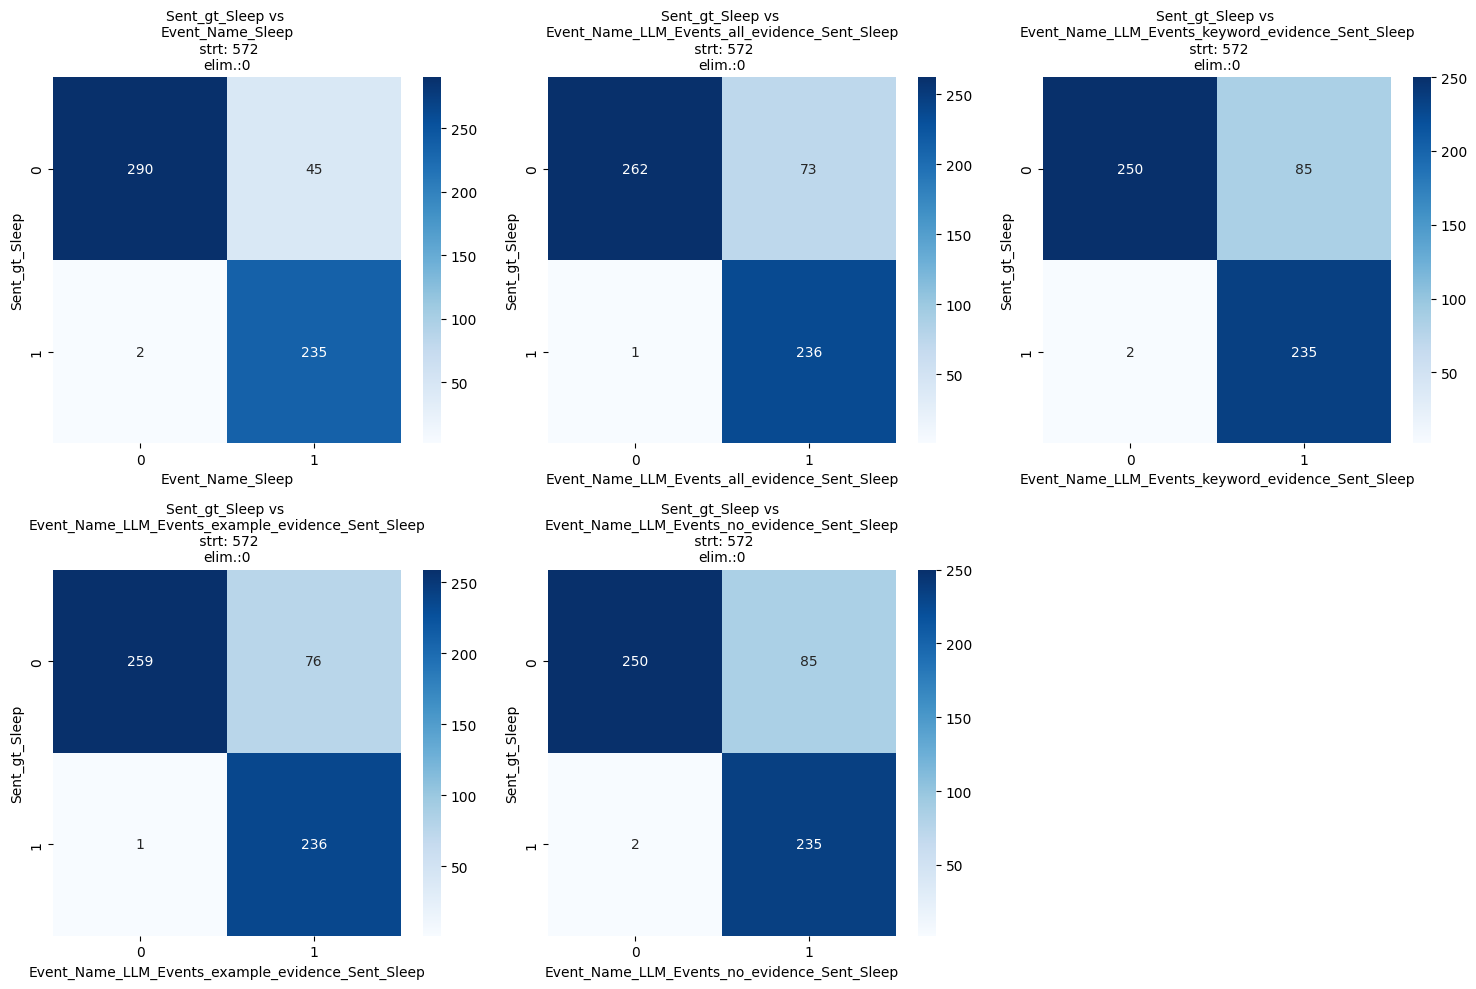

In [8]:
from glob import glob
import os
import pandas as pd
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from itertools import product
disagreement_type = "correct"
llm_type = "llama3.1:70b"
suffix = "19sep"
def get_time(x):
    x = np.array(x)
    # Remove NaNs
    x = x[~np.isnan(x)]
    # If less than 3 values, just return mean
    if len(x) < 3:
        return np.mean(x)
    # Remove outliers using IQR
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    mask = (x >= q1 - 1.5 * iqr) & (x <= q3 + 1.5 * iqr)
    return np.mean(x[mask])

def fixnames(ls,suffix,remove):
    LS=[]
    for s in ls:
        s = s.replace("_keyword_evidence","_Ki").replace("_example_evidence","_Ei").replace("_no_evidence","").replace("_all_evidence","KiEi").replace("Event_Name_",'').replace("_Events",'_').replace('_'+remove,"")
        s = s + "_" + suffix
        if "sentence" in s:
            s = s.replace("sentence","")
            s = s + "_Sent-SET"
        elif "document" in s:
            s = s.replace("document","")
            s = s + "_Doc-SET"
        LS.append(s)
    return LS

def get_col_suffix(keyword_input, example_input):
    col_suffix = "no"
    if keyword_input and example_input:
        col_suffix = "all"
    elif keyword_input and not example_input:
        col_suffix = "keyword"
    elif not keyword_input and example_input:
        col_suffix = "example"
    return col_suffix

LLM_dict = {}
llm_models_all = []
for keyword_input, example_input in [i for i in product([True,False],[True,False])]: 
    for input_type in ["Sent", "Doc"]:
        col_suffix = get_col_suffix(keyword_input, example_input)
        llm_models_all.append(f"LLM_Events_{col_suffix}_evidence_{input_type}")
df_both = pd.read_pickle("../exports/04_dictionary_features.pkl")


dataset = "P-SET"
for analysis_type in ["all"]: #(M-SET, A-SET, D-SET, F-SET)
    for ET in ["Sleep"]:
        print(f"********************{ET}************************")
        llm_files = glob(f"../exports/05_llm_{llm_type}_{dataset}_{suffix}/{ET}/*.pkl")
        print(llm_files)
        try:
            gt_file_sent = glob(f"../exports/04_groundtruth/{dataset}/Annotated/{ET}_Sentences.pkl")[0]
            gt_file_doc = glob(f"../exports/04_groundtruth/{dataset}/Annotated/{ET}_Documents.pkl")[0]
        except IndexError:
            print(f"No ground truth file found for {ET} in ../exports/04_groundtruth/{dataset}/Annotated/")
            continue    
        
        llm_files = [i for i in llm_files if "True" in i]
        llm_files = [i for i in llm_files if "Sent" in i]
        for file in llm_files:
            filename = os.path.basename(file).rstrip('.pkl')
            print(filename)
            text_type = "Document" if "Document" in filename else "Sentence"
            _,attribute_requested = filename.split("_")[-2:]
            attribute_requested = eval(attribute_requested)
            suffix = "Ao" if attribute_requested else ""           
            print(suffix,attribute_requested,filename)
            
            if text_type == "Sentence":
                gt_file = gt_file_sent
                id_type = "UID"
                gt_column = f"Sent_gt_{ET}"
            elif text_type == "Document":
                gt_file = gt_file_doc
                id_type = "ROW_ID"
                gt_column = f"Doc_gt_{ET}"
            print(f"****************{text_type}**************")
            gt_df = pd.read_pickle(gt_file)
            gt_df[id_type] = gt_df[id_type].astype(str)
            df_both[id_type] = df_both[id_type].astype(str)
            gt_df = gt_df.dropna(subset=gt_column)
            if not attribute_requested:
                gt_df[gt_column] = gt_df.apply(lambda x: x[gt_column] if x['negation']==False else False,axis=1)
            
            gt_df['Lemma'] = gt_df['Lemma'].apply(lambda x: tuple(x))
            gt_df["is_keyword_present"] = gt_df["Event_Name"].apply(lambda x: 1 if ET in x else 0)
            
            id_to_gt = {row[id_type]:row[gt_column] for _,row in gt_df.iterrows()}
            id_to_negation = {row[id_type]:row['negation'] for _,row in gt_df.iterrows()}
            id_to_key_present = {row[id_type]:row[f"is_keyword_present"] for _,row in gt_df.iterrows()}
            print(f"^^^^^^^^^^^^^^^^^^{gt_df.is_keyword_present.value_counts()}:{id_to_key_present}")
            id_to_lemma = {row[id_type]:row[f"Lemma"] for _,row in gt_df.iterrows()}
            id_to_dict_time = {row[id_type]:row[f"Time"] for _,row in df_both.iterrows()}
            output_folder = f"../exports/06_analysis/{ET}"
            os.makedirs(output_folder,exist_ok=True)
       
            
            
            df = pd.read_pickle(file)
            df[id_type] = df[id_type].astype(str)
            llm_models = [i for i in llm_models_all if i in df]
            df[f'{ET}_time'] = df[id_type].apply(lambda x:id_to_dict_time.get(x))
            df["focus_event"] = ET
            df['negation'] = df[id_type].apply(lambda x:id_to_negation.get(x))
            
            
            df[gt_column] = df[id_type].apply(lambda x:id_to_gt.get(x,None))
            df[f"is_keyword_present"] = df[id_type].apply(lambda x:id_to_key_present.get(x))
            display(df.is_keyword_present.value_counts())
            print(df[[gt_column,"is_keyword_present"]].value_counts())
                        
            df[f"dict_Lemma"] = df[id_type].apply(lambda x:id_to_lemma.get(x))
            df.dropna(subset=gt_column,inplace=True)
            df[gt_column] = df[gt_column].astype(int)
            

            for col in llm_models:
                df[f"{col}_{ET}_time"] = df[col].apply(lambda x:x['event_detection_time'])
            if len(df) > 1:
                first_row = df.iloc[0]
                splittable_columns = ["Event_Name"]+[f"Event_Name_{model}" for model in llm_models]
                disagreement_dfs = []
                generated_columns = []

                for col in splittable_columns:
                    generated_column = f"{col}_{ET}"
                    df[generated_column] = df[col].apply(lambda x: 1 if ET in x else 0)
                    
                    generated_columns.append(generated_column)
                
                f1s, accs, precs, recs, psup, nsup, times, tp, tn, fp, fn = [],[],[],[],[],[],[],[],[],[],[]
                
                
                for col in generated_columns:
                    print(col)
                    df_temp = df.copy()
                    y_gt = df_temp[gt_column]
                    LLM_dict[(attribute_requested,gt_column)] = y_gt
                    preds = df_temp[col]
                    LLM_dict[(attribute_requested,col)] = preds
                    f1s.append(f1_score(y_gt, preds))
                    accs.append(accuracy_score(y_gt, preds))
                    precs.append(precision_score(y_gt, preds, zero_division=0))
                    recs.append(recall_score(y_gt, preds))   
                    psup.append(sum(y_gt))
                    nsup.append(sum(y_gt==0))
                    times.append(get_time(df_temp[f"{col.lstrip('Event_Name_')}_time"]))
                    #true positive
                    tn_i, fp_i, fn_i, tp_i = confusion_matrix(y_gt, preds).ravel()
                    tp.append(tp_i)
                    tn.append(tn_i)
                    fp.append(fp_i)
                    fn.append(fn_i)
                
            
                results_df = {"col_name":generated_columns, "technique":fixnames(generated_columns,suffix,ET), "pos_sup": psup, "neg_sup": nsup, "f1_score":f1s, "precision":precs, "recall":recs, "TP":tp, 'TN':tn, 'FP':fp, 'FN':fn, "time":times} 
                results = pd.DataFrame(results_df)   
                plot_confusion_matrices_for_column_pairs(df, gt_column,vis_columns=generated_columns)
                op_path = f"{output_folder}/{analysis_type}_{disagreement_type}_{filename}.xlsx"


                df.to_excel(op_path,index=False)
                print(f"file written to {op_path}")
                display(results)

In [89]:
df_temp[f"{col.lstrip('Event_Name_')}_time"]

0     None
2     None
3     None
4     None
5     None
6     None
7     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
18    None
19    None
20    None
Name: Sleep_time, dtype: object

In [ ]:
afile="../exports/06_analysis/Sleep/all_correct_Sleep_Sentences_att_True.xlsx"
amodel = "Event_Name_LLM_Events_all_evidence_Sent_Sleep"
agt = "Sent_gt_Sleep"

adf = pd.read_excel(afile)
adf[adf[amodel]!=adf[agt]][['Sentence',agt,amodel]].to_excel(f"../exports/temp_false_predictions.xlsx")


In [71]:
id_to_gt = {row[id_type]:row[gt_column] for _,row in gt_df.iterrows()}
set(id_to_gt.values())

{False}

In [77]:
row['Sent_ID']

NameError: name 'row' is not defined

In [26]:
df.Sentence

724                                      micu nursing note
724                                             [**7-18**]
724      [**name (ni) **] patient is awake and alert, o...
724      patient given .5mg by mouth ativan x1 with goo...
724      it patient needs ativan more often like q6 to ...
                               ...                        
14452               will discuss this with team in morning
14452                                      hct stable @ 35
14452    bs treated per ssri.plan) continue by mouth an...
14452                           advance adl's & dat as tol
14452             make team aware of back & abdominla pain
Name: Sentence, Length: 4618, dtype: object

In [1]:
print(f"{output_folder}/{analysis_type}_{disagreement_type}_{filename}.xlsx")

NameError: name 'output_folder' is not defined

In [12]:
from pprint import pprint
pprint(df_temp[(df_temp[gt_column]==False) & (df_temp[col]==True) & (df_temp["Event_Name_Sleep"]==False)][[id_type,text_type, gt_column, col]].to_string())

('     '
 'ROW_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [65]:
gt_df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'Document',
       'AGE', 'LOS_DAYS', 'IS_ALIVE', 'DOCUMENT_LOWER', 'NUM_NOTES',
       'MAX_NOTES_PER_DAY', 'MAX_NOTES_PER_CHARTTIME', 'all_dates_present',
       'Sentences', 'Sentences_Raw', 'Sentences_Cleaned', 'Events', 'Sent_ID',
       'UID', 'Event_Name', 'Sentence', 'Time', 'Keyword', 'Lemma',
       'Keyword_Position', 'Event_Name_Pain', 'Event_Name_Pain_doc',
       'Event_Name_Sleep', 'Event_Name_Sleep_doc', 'is_keyword_present',
       'Sent_gt_Sleep', 'negation', 'good_example', 'comment'],
      dtype='object')

In [46]:
df = pd.read_pickle(file)
llm_models = [i for i in llm_models_all if i in df]
file,llm_models, df.columns

('../exports/05_llm_llama3.1:70b_P-SET/Sleep/Sleep_Sentences_att_True.pkl',
 ['LLM_Events_all_evidence_Sent',
  'LLM_Events_keyword_evidence_Sent',
  'LLM_Events_example_evidence_Sent',
  'LLM_Events_no_evidence_Sent'],
 Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
        'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'Document',
        'AGE', 'LOS_DAYS', 'IS_ALIVE', 'DOCUMENT_LOWER', 'NUM_NOTES',
        'MAX_NOTES_PER_DAY', 'MAX_NOTES_PER_CHARTTIME', 'all_dates_present',
        'Sentences', 'Sentences_Raw', 'Sentences_Cleaned', 'Events', 'Sent_ID',
        'UID', 'Event_Name', 'Sentence', 'Time', 'Keyword', 'Lemma',
        'Keyword_Position', 'Event_Name_Pain', 'Event_Name_Pain_doc',
        'Event_Name_Sleep', 'Event_Name_Sleep_doc', 'is_keyword_present',
        'LLM_Events_all_evidence_Sent',
        'Event_Name_LLM_Events_all_evidence_Sent',
        'Attribute_LLM_Events_all_evidence_Sent',
        'Text_Quotes_LLM_Events_all_evidence_Sent',

In [47]:
file

'../exports/05_llm_llama3.1:70b_P-SET/Sleep/Sleep_Sentences_att_True.pkl'

In [18]:
text_type ="Document" 
file = f'../exports/05_llm_llama3.1:70b_P-SET/Sleep/Sleep_{text_type}s_att_True.pkl'
llm_df = pd.read_pickle(file)
for llm_model in llm_models:
    llm_df['tqvalid']=llm_df.apply(lambda x:[i in x[text_type] for i in x[f"Text_Quotes_{llm_model}"]], axis=1)
    print(llm_model, llm_df['tqvalid'].explode().value_counts())
# Text_Quotes_LLM_Events_all_evidence_Sent


LLM_Events_all_evidence_Doc tqvalid
True     757
False     83
Name: count, dtype: int64
LLM_Events_keyword_evidence_Doc tqvalid
True     802
False     98
Name: count, dtype: int64
LLM_Events_example_evidence_Doc tqvalid
True     840
False    100
Name: count, dtype: int64


In [59]:
llm_models

['LLM_Events_all_evidence_Sent',
 'LLM_Events_keyword_evidence_Sent',
 'LLM_Events_example_evidence_Sent',
 'LLM_Events_no_evidence_Sent']

In [16]:
col

'Event_Name_Sleep'

{1277038: 0,
 1277048: 1,
 1277049: 0,
 1277050: 0,
 1277051: 1,
 1277052: 0,
 1277053: 0,
 1277054: 0,
 1277055: 0,
 1277056: 0,
 1277057: 0,
 1277058: 0,
 1277059: 0,
 1277060: 1,
 1277061: 0,
 1277062: 0}

In [4]:
df.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'DOCUMENT',
       'AGE', 'LOS_DAYS', 'IS_ALIVE', 'DOCUMENT_LOWER', 'NUM_NOTES',
       'MAX_NOTES_PER_DAY', 'MAX_NOTES_PER_CHARTTIME', 'all_dates_present',
       'Sentences', 'Sentences_Raw', 'Sentences_Cleaned', 'Events', 'Sent_ID',
       'UID', 'Event_Name', 'Sentence', 'Time', 'Keyword', 'Lemma',
       'Keyword_Position', 'LLM_Events_all_evidence_sentence',
       'Event_Name_LLM_Events_all_evidence_sentence',
       'Attribute_LLM_Events_all_evidence_sentence',
       'LLM_Events_keyword_evidence_sentence',
       'Event_Name_LLM_Events_keyword_evidence_sentence',
       'Attribute_LLM_Events_keyword_evidence_sentence',
       'LLM_Events_example_evidence_sentence',
       'Event_Name_LLM_Events_example_evidence_sentence',
       'Attribute_LLM_Events_example_evidence_sentence',
       'LLM_Events_no_evidence_sentence',
       'Event_Name_LLM_Eve

In [5]:
df[["DOCUMENT","Event_Name_LLM_Events_keyword_evidence_document_Ao","Sentence" ,"GT_Sleep"]].to_excel("../exports/temp_result.xlsx",index=False)

KeyError: "['Event_Name_LLM_Events_keyword_evidence_document_Ao'] not in index"

In [ ]:
'dictionary_Sleep_time' in df.columns, llm_models

(False,
 ['LLM_Events_all_evidence_sentence',
  'LLM_Events_all_evidence_document',
  'LLM_Events_keyword_evidence_sentence',
  'LLM_Events_keyword_evidence_document',
  'LLM_Events_example_evidence_sentence',
  'LLM_Events_example_evidence_document',
  'LLM_Events_no_evidence_sentence',
  'LLM_Events_no_evidence_document'])

In [ ]:
y_gt.value_counts()

GT_Sleep
0    297
1      3
Name: count, dtype: int64

In [ ]:
gt_df.Keyword.value_counts()

In [ ]:
df_dictionary = pd.read_pickle(f"../exports/03_selected_reports_with_event_log_only_dictionary_v2/combined.pkl")

In [ ]:
df_dictionary['Events'].iloc[0]

In [ ]:
import pandas as pd
from glob import glob
ET = "Sleep"
df = pd.read_pickle(glob(f"../exports/04_groundtruth/P-SET/Generated/{ET}*.pkl")[0])
print(df.UID.nunique(), df.Sentence.nunique(), df.ROW_ID.nunique(), df.SUBJECT_ID.nunique(), df.Event_Name.value_counts())

df_exploded = df.explode(['Keyword','Lemma','Event_Name','Keyword_Position'])
df_exploded['KUID'] = df_exploded['UID'] + "_" + df_exploded['Keyword_Position'].astype(str)
print(df_exploded.Event_Name.value_counts(),df_exploded[df_exploded.Event_Name==ET]['Lemma'].value_counts())

# df[['SUBJECT_ID', 'LOS_DAYS', 'AGE']].drop_duplicates().mean()




4783 4435 210 10 Event_Name
[Unknown]                                  4311
[Sleep]                                     114
[Pain]                                      112
[Family]                                    101
[Excretion]                                  66
[Eating]                                     21
[Sleep, Sleep]                               16
[Pain, Pain]                                 16
[Pain, Sleep]                                 7
[Family, Sleep]                               4
[Eating, Eating]                              3
[Family, Pain]                                2
[Family, Family]                              2
[Family, Family, Family, Family]              1
[Family, Pain, Sleep, Sleep]                  1
[Sleep, Sleep, Sleep]                         1
[Eating, Family, Sleep]                       1
[Excretion, Excretion]                        1
[Family, Family, Family, Family, Sleep]       1
[Family, Family, Family]                      1
[Pain, Pain,

In [ ]:
df_exploded[df_exploded.Event_Name=="Sleep"].to_excel("../exports/temp_sleep_keywords.xlsx")

In [ ]:
top10_patients = df_exploded[df_exploded.Event_Name=="Sleep"].SUBJECT_ID.unique().tolist()

In [ ]:
df[df.SUBJECT_ID.isin(top10_patients)].to_excel("../exports/temp_top10_patients_all_events.xlsx")